# Maestría en Inteligencia Artificial Aplicada

## Navegción Autónoma

##**Actividad 3.1 - Detección de Peatones con SVM**

Equipo 18:



*   Laura Irán González Ojeda - A01794099
*   Emmanuel Francisco González Velázquez - A01364577
*   Fabiola Sosa Hernández- A01240145
*   Jorge Fernández Lara - A01793062
*   Jonathan Puga Castellanos - A01795204




Saving pedestrian-detection-metadata.json to pedestrian-detection-metadata.json
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/karthika95/pedestrian-detection
License(s): unknown
 95% 177M/187M [00:02<00:00, 93.1MB/s]
100% 187M/187M [00:02<00:00, 71.0MB/s]


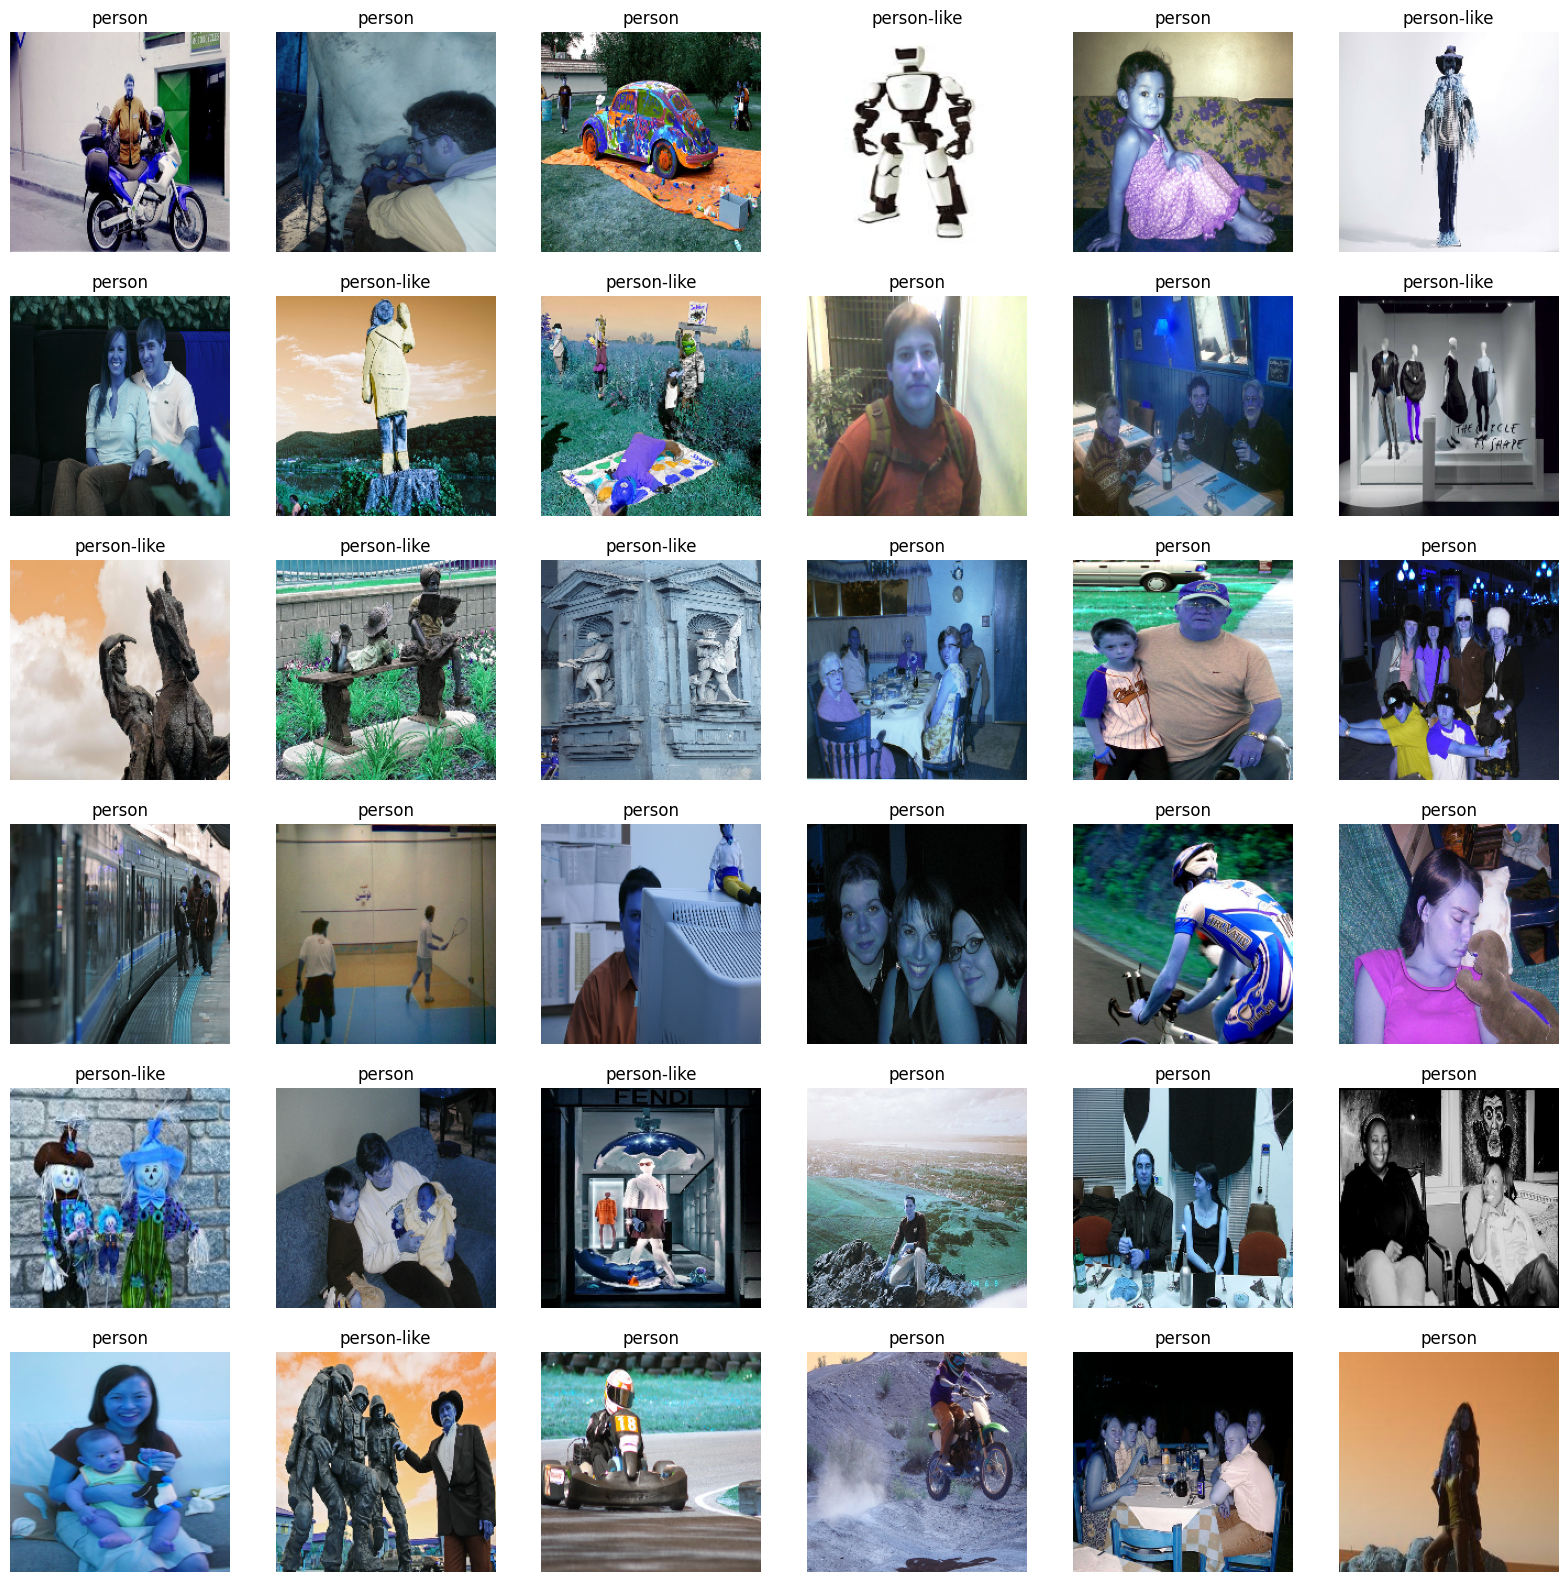

In [1]:
# Importación de librerías necesarias para procesamiento de imágenes, visualización y manejo de archivos
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from skimage.feature import hog
from xml.etree import ElementTree
import os
from google.colab import files

# Subir el archivo de configuración de la API de Kaggle para acceder a los datasets
files.upload()

# Configuración del entorno para utilizar la API de Kaggle
!mkdir -p ~/.kaggle                    # Crear el directorio para configuración de Kaggle
!mv kaggle.json ~/.kaggle/             # Mover el archivo de configuración al directorio adecuado
!chmod 600 ~/.kaggle/kaggle.json       # Cambiar permisos para asegurar que el archivo es accesible

# Instalación de la API de Kaggle para descargar datasets
!pip install kaggle

# Descargar y descomprimir el dataset de detección de peatones desde Kaggle
!kaggle datasets download -d karthika95/pedestrian-detection --unzip -p /content/pedestrian_dataset

# Definición de las clases y su asignación a índices para facilitar su manejo
class_names = ['person', 'person-like']
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

# Definición del número de clases y tamaño de las imágenes para procesamiento uniforme
n_classes = 2
size = (200, 200)

# Función para cargar y procesar los datos desde los directorios especificados
def load_data():
    datasets = ['Train/Train', 'Test/Test', 'Val/Val']
    output = []

    for dataset in datasets:
        images = []
        labels = []
        directoryA = "/content/pedestrian_dataset/" + dataset + "/Annotations"
        directoryIMG = "/content/pedestrian_dataset/" + dataset + "/JPEGImages/"
        file = os.listdir(directoryA)
        img = os.listdir(directoryIMG)
        file.sort()
        img.sort()

        i = 0
        for xml in file:
            xmlf = os.path.join(directoryA, xml)
            dom = ElementTree.parse(xmlf)
            vb = dom.findall('object')
            label = vb[0].find('name').text
            labels.append(class_names_label[label])

            img_path = directoryIMG + img[i]
            curr_img = cv2.imread(img_path)
            curr_img = cv2.resize(curr_img, size)
            images.append(curr_img)
            i += 1

        images = np.array(images, dtype='float32')
        images /= 255  # Normalizar las imágenes dividiendo cada pixel entre 255

        labels = np.array(labels, dtype='int32')

        output.append((images, labels))
    return output

# Cargar datos de entrenamiento, prueba y validación
(train_images, train_labels), (test_images, test_labels), (val_images, val_labels) = load_data()

# Visualización de algunas imágenes de entrenamiento
plt.figure(figsize=(20, 20))
for n, i in enumerate(list(np.random.randint(0, len(train_images), 36))):
    plt.subplot(6, 6, n + 1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i]])
    plt.axis('off')


Accuracy: 0.6893617021276596
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       136
           1       0.64      0.60      0.62        99

    accuracy                           0.69       235
   macro avg       0.68      0.68      0.68       235
weighted avg       0.69      0.69      0.69       235



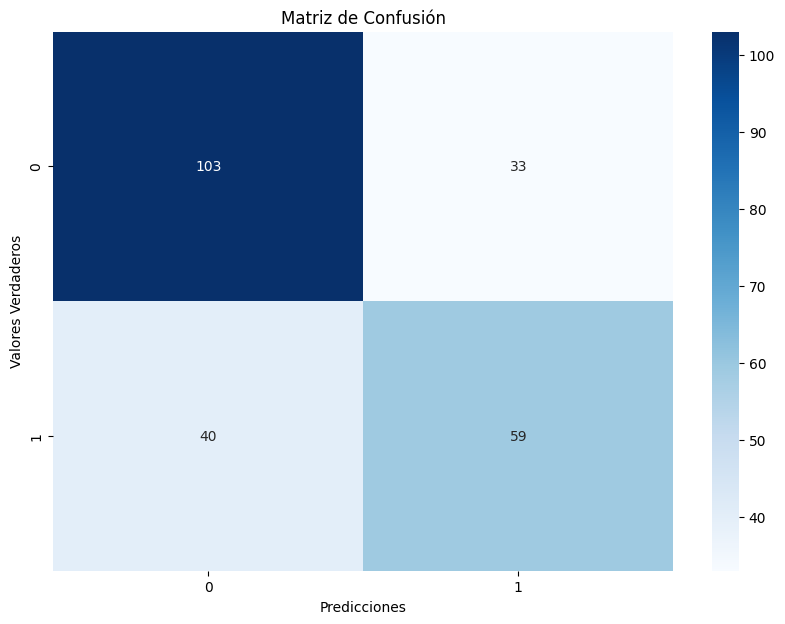

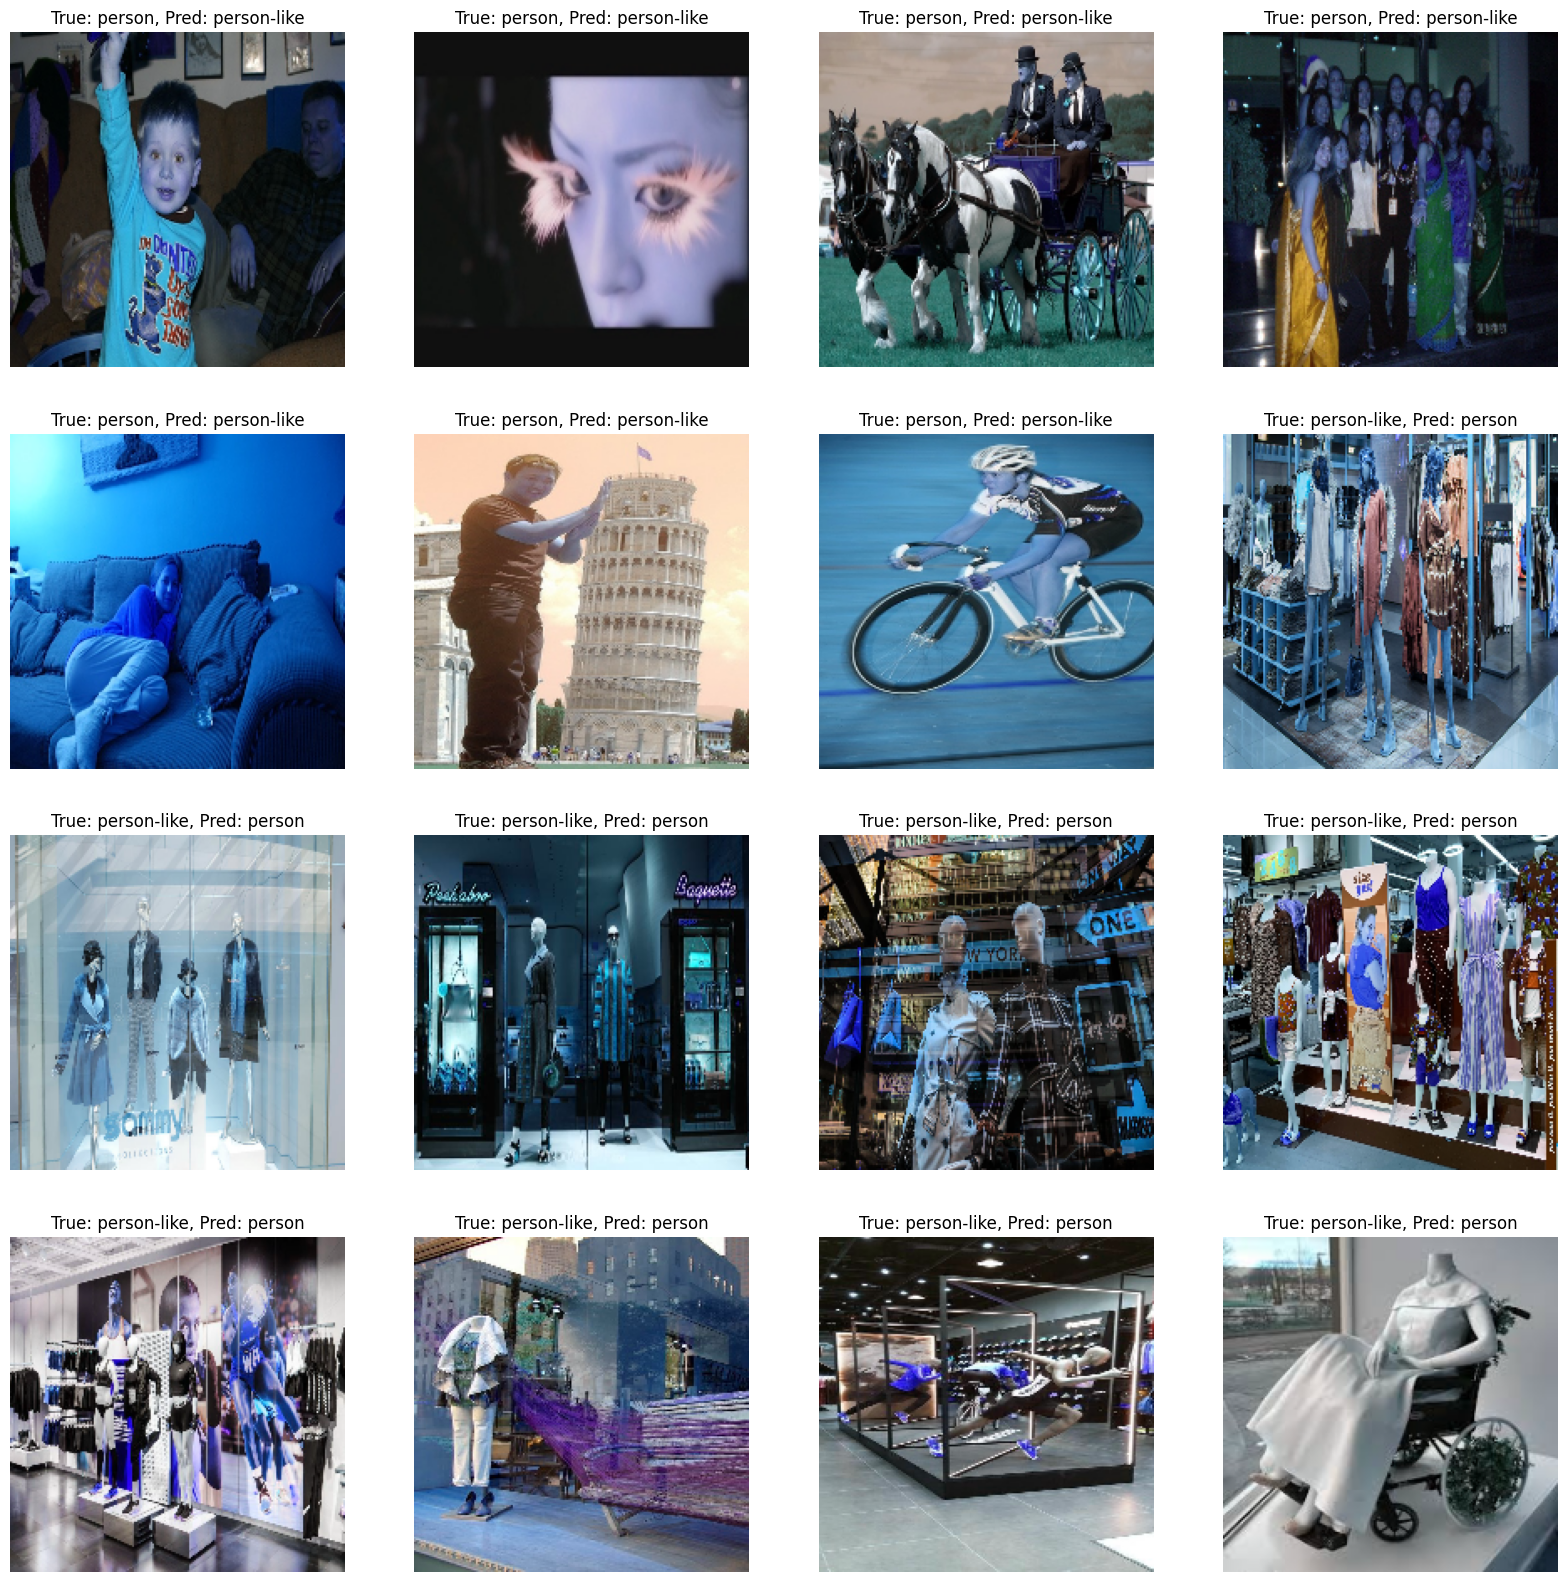

In [3]:
# Importación de librerías adicionales necesarias para el entrenamiento y evaluación del modelo
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Función para extraer características HOG de cada imagen, ahora incluyendo la conversión a escala de grises
def extract_features(images):
    features = []
    for img in images:
        # Conversión de la imagen a escala de grises
        if img.ndim == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        hog_feature, _ = hog(img,
                             orientations=9,
                             pixels_per_cell=(8, 8),
                             cells_per_block=(2, 2),
                             transform_sqrt=True,
                             visualize=True,
                             feature_vector=True)
        features.append(hog_feature)
    return features

# Extracción de características para cada conjunto de datos
train_features = extract_features(train_images)
test_features = extract_features(test_images)
val_features = extract_features(val_images)

# Entrenamiento del modelo SVM
model = svm.SVC(kernel='linear', C=1.0, random_state=42)  # Ajusta el kernel y los parámetros según sea necesario
model.fit(train_features, train_labels)

# Predicciones en el conjunto de prueba
test_predictions = model.predict(test_features)

# Evaluación del modelo
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy: {accuracy}")

# Matriz de confusión
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")

# Reporte de clasificación
print(classification_report(test_labels, test_predictions))

# Visualización opcional de imágenes mal clasificadas (opcional)
misclassified_indices = [i for i, (true, pred) in enumerate(zip(test_labels, test_predictions)) if true != pred]
plt.figure(figsize=(20, 20))
for n, idx in enumerate(misclassified_indices[:16]):  # Muestra las primeras 16 imágenes mal clasificadas
    plt.subplot(4, 4, n + 1)
    plt.imshow(test_images[idx])
    plt.title(f"True: {class_names[test_labels[idx]]}, Pred: {class_names[test_predictions[idx]]}")
    plt.axis('off')
